# IVP Lab Exam 

Shreya Punjabi

191061054

TY Btech Electronics

## Problem Statement:

License plate recognition using image processing

**Part 1: Pre Processing**

Step 1: Importing required packages

In [ ]:
import cv2
import numpy as np
from imutils import contours
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance
import pytesseract
import shutil
import os
import random

In [ ]:
#!sudo apt install tesseract-ocr
#!pip install pytesseract
#!pip install --ignore-installed Pillow==9.0.0

     |████████████████████████████████| 4.3 MB 14.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Step2: Loading the image

In [ ]:
#load image
loaded_img = cv2.imread("ford.jpg",)
loaded_img.shape

(768, 1024, 3)

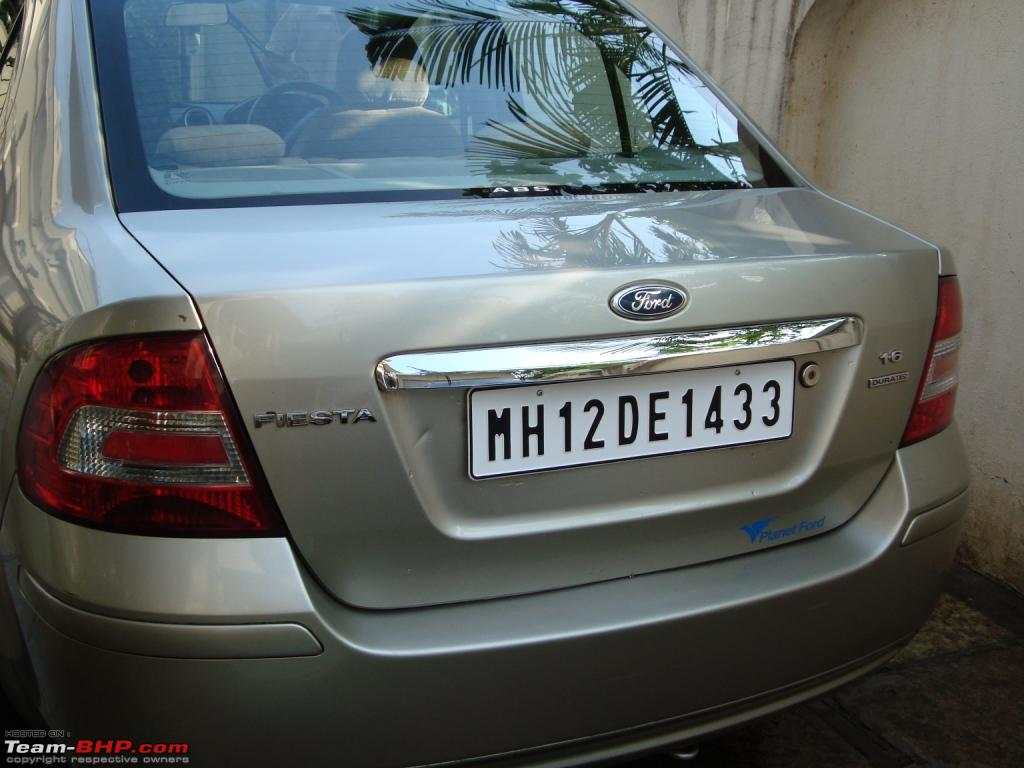

In [ ]:
cv2_imshow(loaded_img)

Step 3: Undersampling to reduce dimensions of high quality images

In [ ]:
#undersampling
def scale_down(img):
    x_dim = 640
    width =  int((x_dim * img.shape[1])/img.shape[0])
    height =   x_dim 

    print(height, width)

    img = cv2.resize(img, (width, height))
    #cv2_imshow(img)
    return img

Step 4: Converting image from BGR colour space to HSV and extracting only the V channel

In [ ]:
def get_value(img):
    #convert to hsv, use only v array.
    #This ensures working of the algorithm for 
    #images with a wide range of illumination. 
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(img_hsv)

    return v

Step 5: Applying a Gaussian blur to reduce unnecessary noise and detail

In [ ]:
def gaussian_blur(img, kernel_size):
    #Gaussian blur
    img_gauss = cv2.GaussianBlur(img, (kernel_size,kernel_size), 0) 
    #cv2_imshow(img_gauss) 
    return img_gauss

Step 6: Increasing contrast of the image for better detection of plate

In [ ]:
def increase_contrast(image, factor):

  im = Image.fromarray(image)
  enhancer = ImageEnhance.Contrast(im)
  #factor = 2.0
  enhanced_contr = enhancer.enhance(factor)
  im = np.array(enhanced_contr)
  return im

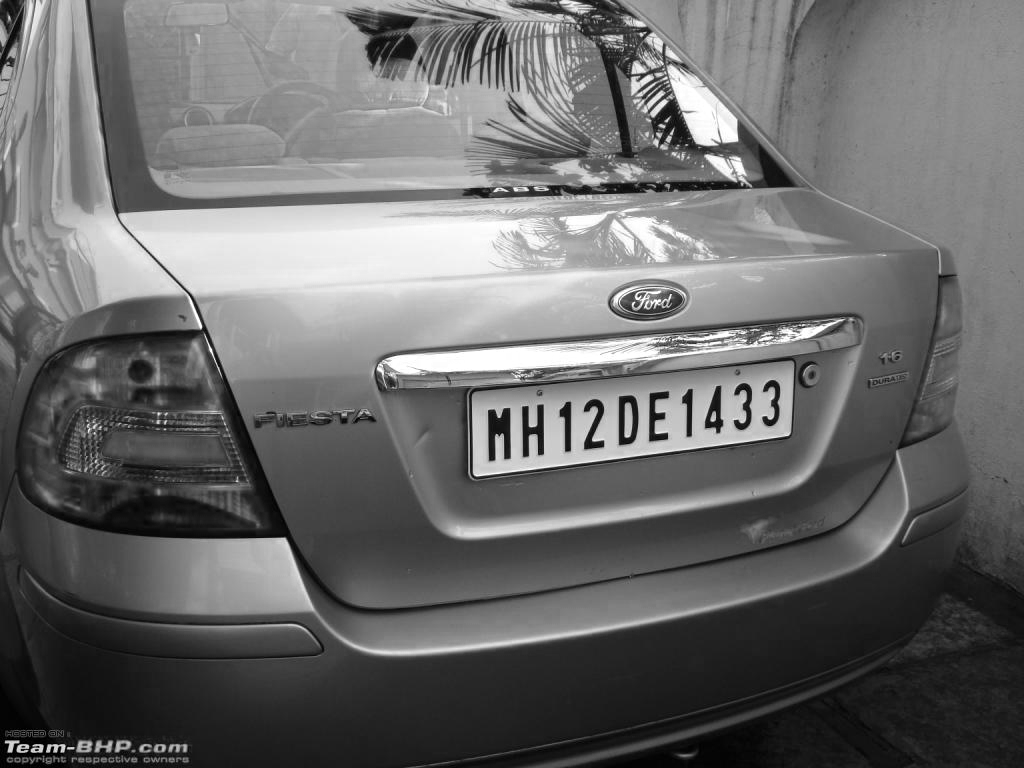

In [ ]:
v = get_value(loaded_img)
original = v.copy()
cv2_imshow(v)

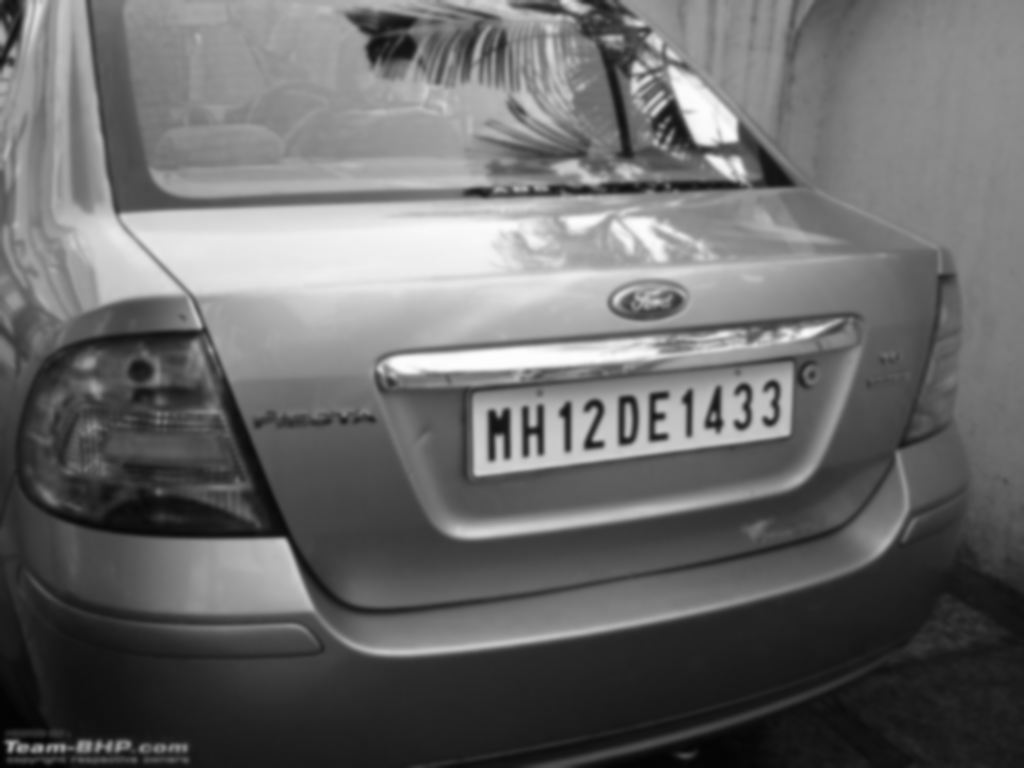

In [ ]:
gauss_blur = gaussian_blur(v, 11)
cv2_imshow(gauss_blur)

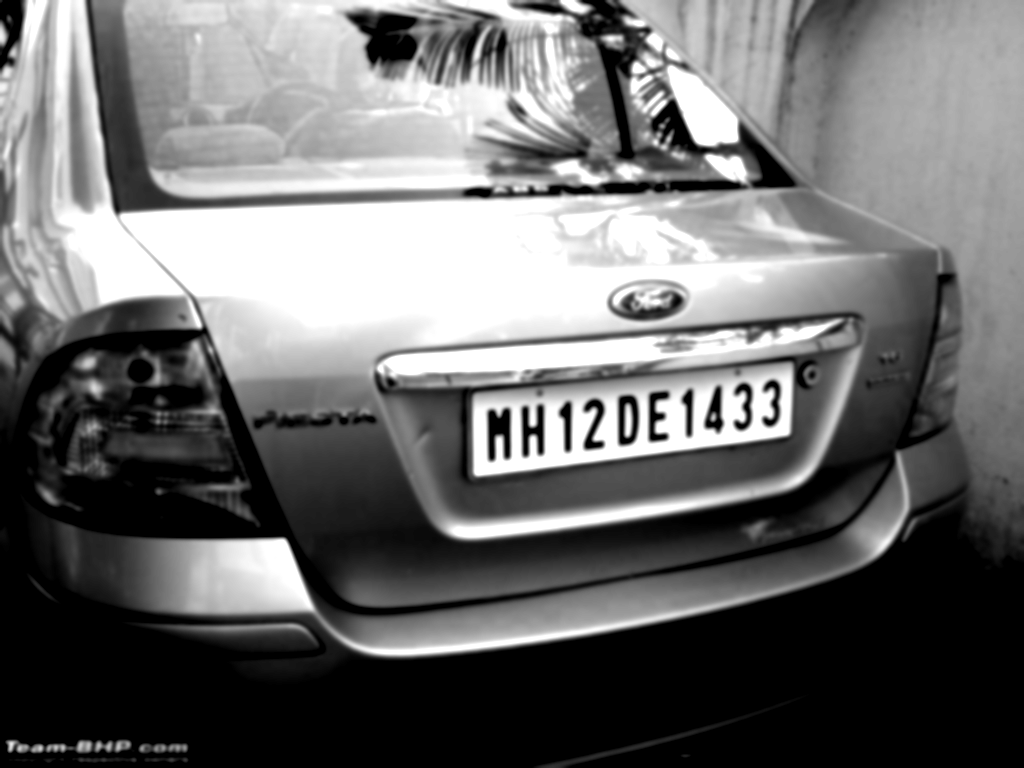

In [ ]:
incr_con = increase_contrast(gauss_blur,2.0)
cv2_imshow(incr_con)

img = incr_con.copy()

Step 7: Apply blackhat transform and calculate original image added to blackhat transform. 

This gives us a clearer light coloured rectangle in place of the number plate.

In [ ]:
def morphological_transf(img):

    #morphological transformations- top hot and black hat filters-
    #top hat results are added to orig image and black hat are subtracted

    #top hat operation- difference between og image and opening
    #opening- erosion then dilation
    kernel_dims = (13,7) #13,7

    #BLACKHAT IS USED HERE
    rectkernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_dims)
    blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, rectkernel)
    whitehat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, rectkernel)
    #cv2_imshow(img)
    print("Blackhat transform:")
    cv2_imshow(blackhat)
    #cv2_imshow(whitehat)

    result = img+blackhat
    return result


Blackhat transform:


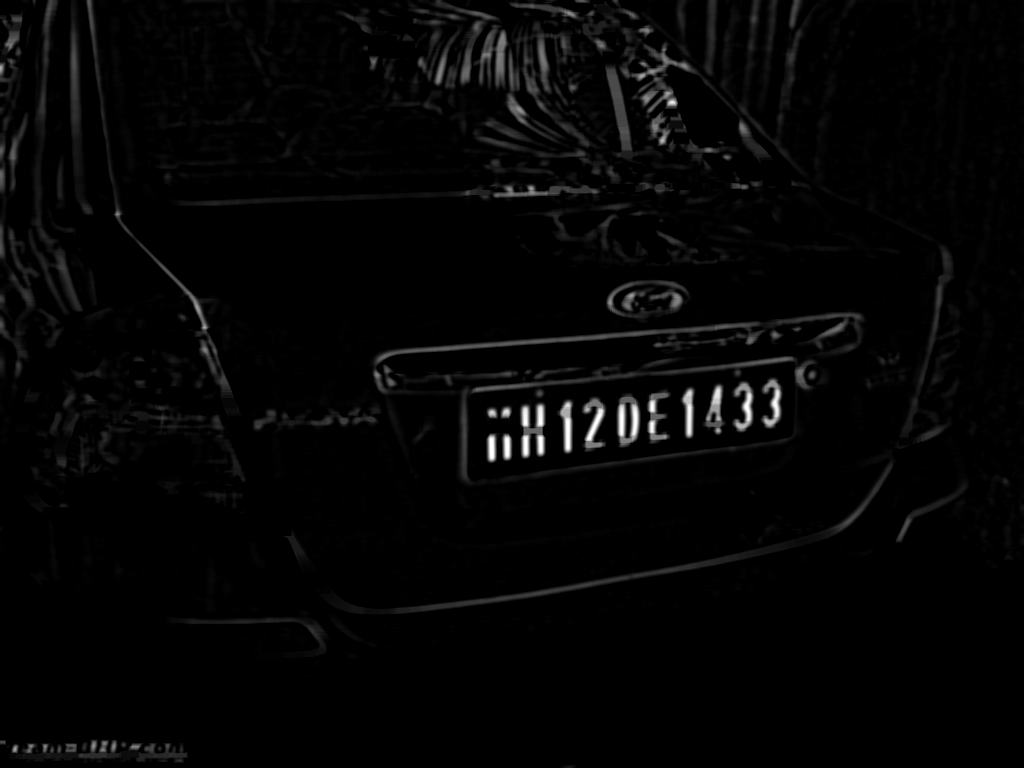

In [ ]:
morph_img = morphological_transf(img)

Image after required morphological transform:

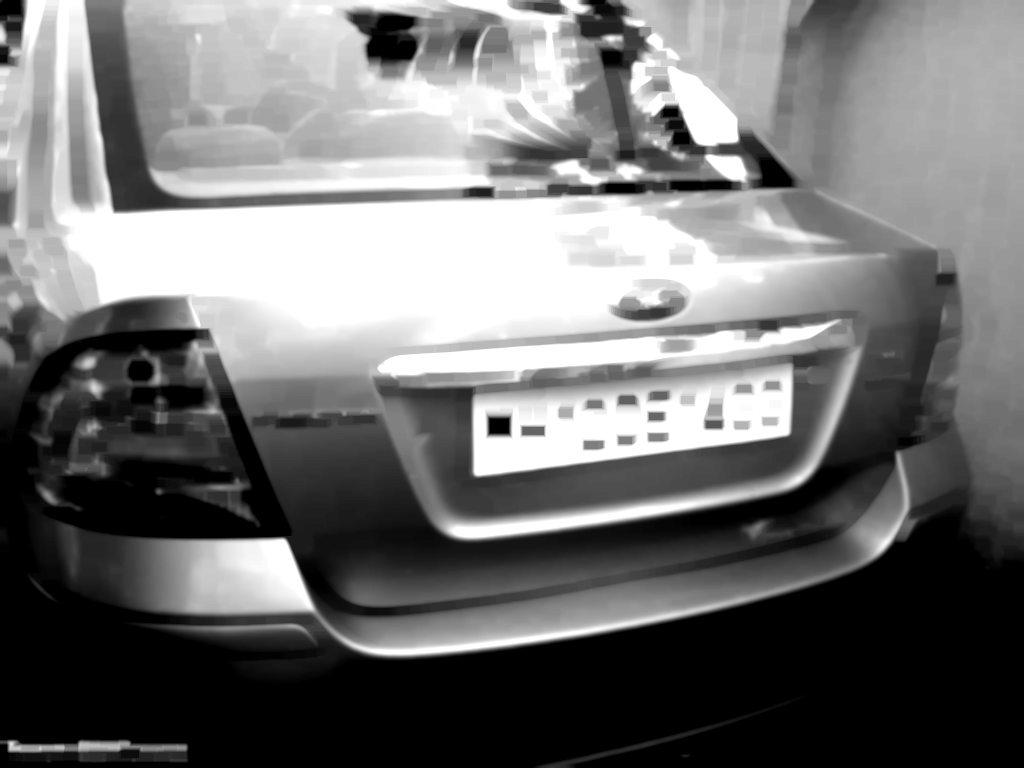

In [ ]:
cv2_imshow(morph_img)

Step 8: Apply adaptive Gaussian thresholding to convert the image to binary

In [ ]:
def thresholding(img):
    block_size = 17 #has to be odd number
    weight = 17

    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, weight)

    #blur = cv2.GaussianBlur(test, (5,5), 0) #has to be an odd number
    #ret2, thresh2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #cv2_imshow(thresh)
    return thresh

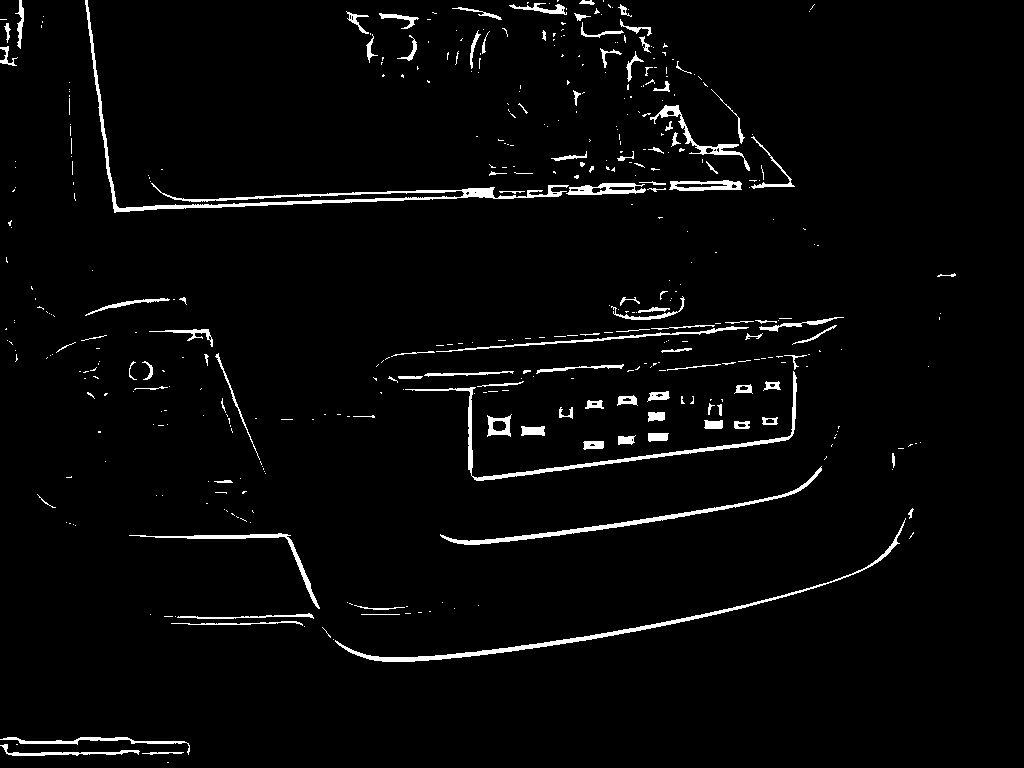

In [ ]:
thresh = thresholding(morph_img)
cv2_imshow(thresh)

Step 9: Apply erosion once with a 2x2 kernel to remove small white dots and detail in the binary image.

In [ ]:
def erosion(img):
    erosion_dims = (2,2)
    erosionkernel = cv2.getStructuringElement(cv2.MORPH_RECT, erosion_dims)
    eroded_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, erosionkernel)
    return eroded_img
    #cv2_imshow(thresh)

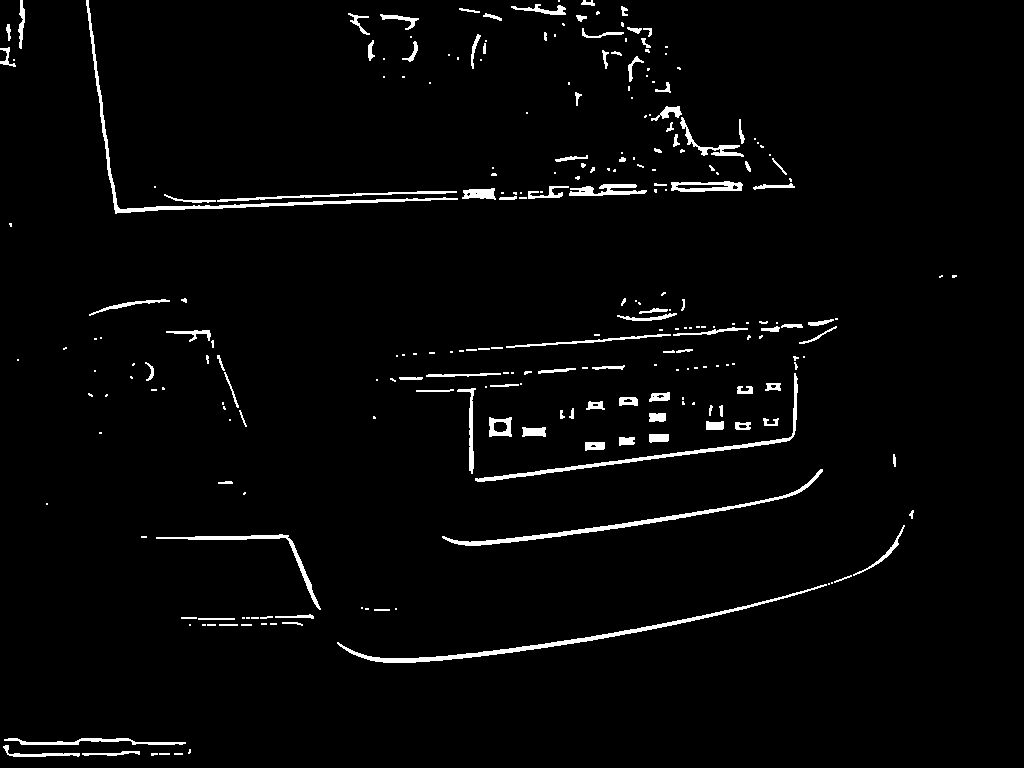

In [ ]:
eroded = erosion(thresh)
cv2_imshow(eroded)

Step 10: Find contours and bounding rectangles of contours. Filter these on the basis of aspect ratio and area.

In [ ]:
#thresh = cv2.threshold(test, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
def get_bounding_boxes(image_to_cut, draw_on, asp_min, asp_max, area_min, area_max):
    ROI_number = 0
    cnts = cv2.findContours(image_to_cut, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    digit_contours = []
    rois = []
    for c in cnts:
        area = cv2.contourArea(c)
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.01 * peri, True)

        x,y,w,h = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        

        if (aspect_ratio >= asp_min and aspect_ratio <= asp_max):
            if area > area_min and area <area_max:
                #print(area)
                #print(aspect_ratio)
                ROI = original[y:y+h, x:x+w]
                cv2.rectangle(draw_on,(x,y),(x+w,y+h),(0,255,0),2)
                digit_contours.append(c)
                rois.append([x,y,w,h])
        #cv2.rectangle(v, (x, y), (x + w, y + h), (0,0,255), 2)

    cv2_imshow(draw_on)
    cv2_imshow(image_to_cut)
    return rois

In [ ]:
v.shape

(768, 1024)

1454.0
6.2025316455696204
1188.5
4.9480519480519485
1023.5
3.1359223300970873


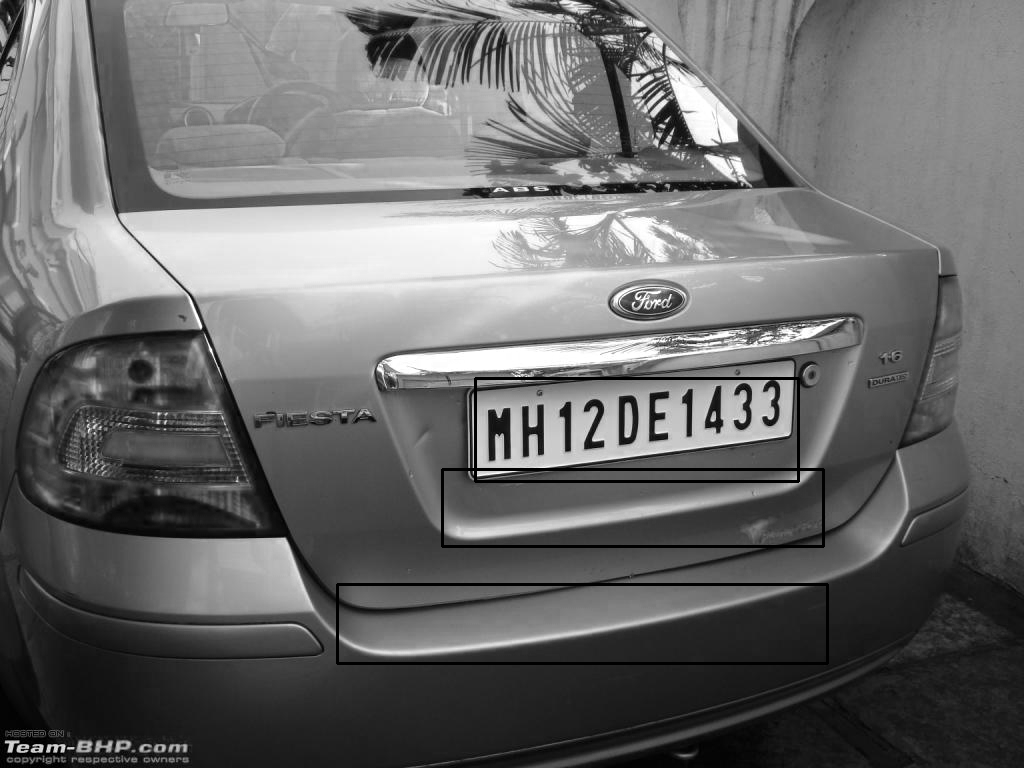

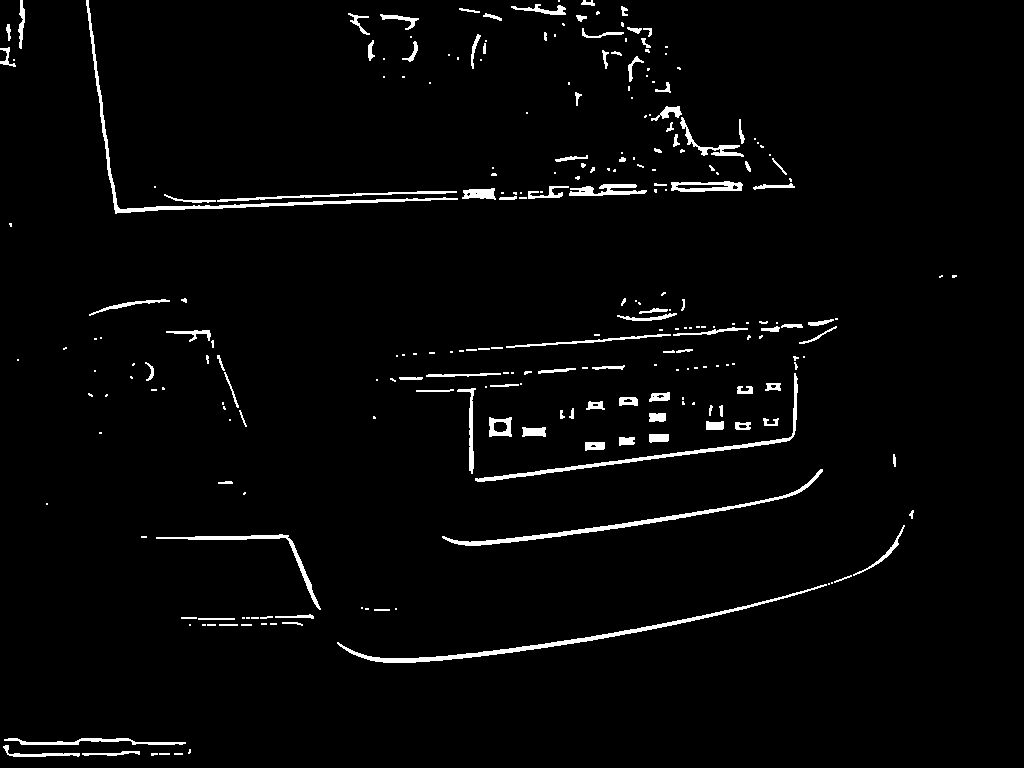

In [ ]:
draw_on = v.copy()
rois = get_bounding_boxes(eroded, draw_on, 3,7, 500, 4000)

Step 11: Get cropped areas as defined by the bounding boxes.

In [ ]:
def get_cropped_areas(source_img, rois, padding):
    cropped_areas = []
    for rect in rois:
      padding=4 #pad cropped rectangle
      x,y,w,h = rect
      print(x,y,w,h)
      img_crop = source_img[y-padding : y+h+padding, x- padding : x+w+ padding]
      cropped_areas.append(img_crop)
      cv2_imshow(img_crop)
    return cropped_areas


337 584 490 79


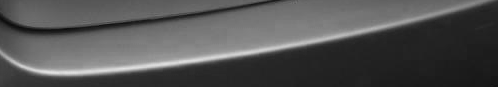

442 469 381 77


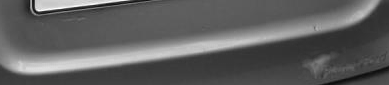

475 378 323 103


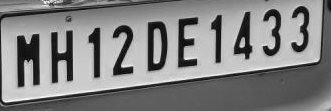

In [ ]:
cropped_areas = get_cropped_areas(original, rois, 4)

Step 12: Perform canny edge detection on all the bounding box areas find. Then we repeat the contour finding process. If we find more than 8 ROIs, we can conclude it is the number plate as a number plate has 10 characters. We save the individual binarised characters of the plate and we perform OCR using Tesseract on the number plate.

In [ ]:
def canny(area):
    canny_area = cv2.Canny(area,100,200)
    #cv2_imshow(area)
    return canny_area

In [ ]:
def get_letters(canny_area, area):
    #letters = []
    blank = area.copy()

    length = area.shape[1]
    height = area.shape[0]


    rois2 = get_bounding_boxes(canny_area, blank, 0.05, 0.6, (length*height)/180, (length*height)/36)
    letters = get_cropped_areas(area, rois2, 2)
    return letters

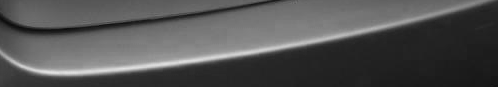

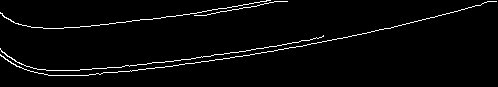

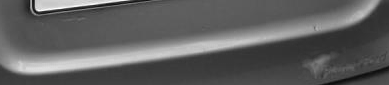

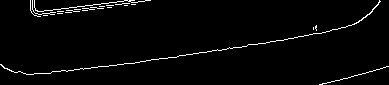

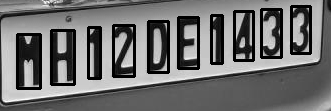

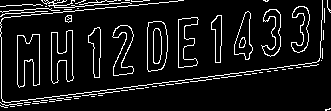

17 34 23 54


51 30 23 54


88 27 12 51


113 25 21 51


148 21 20 51


178 17 20 51


211 15 11 48


234 11 19 49


261 9 20 48


291 6 19 47


In [ ]:
#nb_plate
for area in cropped_areas:
    canny_area = canny(area)
    #cv2_imshow(canny_area)
    letters = get_letters(canny_area, area) 
    if len(letters)>8:
        nb_plate = area
        break

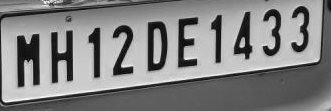

In [ ]:
cv2_imshow(nb_plate)

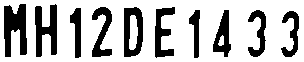

In [ ]:
all_padded = []
m = max([l.shape[0] for l in letters])
#print(m)
for l in letters:
  if l.shape[0] <= m:
    _, l = cv2.threshold(l,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    padded = np.pad(l, (m-l.shape[0],0), 'constant', constant_values=(255))

    all_padded.append(padded)
  #print(padded.shape)
stacked = np.hstack(all_padded)  
cv2_imshow(stacked)

In [ ]:
for l in range((len(all_padded))):
  cv2.imwrite("/content/extracted_letters/letter{}.jpg".format(l+1), all_padded[l])

In [ ]:

string = pytesseract.image_to_string(nb_plate)
print(string)

MH 12DE1433)

